In [12]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
from rl_introduction.tools import Agent, DeepAgent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train
sns.set_style("darkgrid")

In [13]:
env = gym.make('CartPole-v0')

# deep Q-learning

When the state spaces is continous. It is necessary to have a function for the Q value. A common way to represent and update this function, it is to use parametric function (as neural network).
In other words, we are looking for $\theta \in \mathbb{R}^d$ such as 
$\forall s Q_\theta(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$. We follow the same idea as q-learning:
we eant to update $Q_\theta(S_t,A_t)$ using the target $R_{t+1}+\gamma \max_a Q(S_{t+1},a)$. A natural loss is the mean square error:

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y_t - Q(s,a,\theta))^2]$



$y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$

We have 2 ways to write our function:
1. $Q_\theta : S\times A \rightarrow \mathbb{R}$

in this case greedy policy looks like $\pi(.|s) = \arg\max([Q_\theta(s,a_0), Q_\theta(s,a_1),... Q_\theta(s,a_{dim(A)}]) $

The target is $y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$
2. $Q_\theta : S \rightarrow \mathbb{R}^{dim(A)}$

in this case greedy policy looks like $\pi(.|s) = \arg\max(Q_\theta(s))$

The target is $y_i = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$ for i corresponding to the played action, $Q_\theta(s_t)_i$ otherwise.

In [26]:
def build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='linear')(x)
    model = Model(inputs=input_state, outputs=x)
    model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
    return model

In [27]:
class DeepQAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        else:
            predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
            return np.argmax(predicted_Qs) 
    
    def train(self, current_state, action, reward, next_state, done):
        predicted_Q_nexts = self.model.predict(next_state.reshape(1, -1))[0]
        target = self.model.predict(current_state.reshape(1, -1))[0]
        if done is True:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(predicted_Q_nexts)
        self.model.train_on_batch(current_state.reshape(1, -1), target.reshape(1, -1))
        #self.model.fit(current_state.reshape(1, -1), target.reshape(1, -1), batch_size=1, verbose=0, shuffle=False)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 8.0
episode: 1 - cum reward 10.0
episode: 2 - cum reward 10.0
episode: 3 - cum reward 10.0
episode: 4 - cum reward 9.0
episode: 5 - cum reward 11.0
episode: 6 - cum reward 9.0
episode: 7 - cum reward 10.0
episode: 8 - cum reward 10

episode: 241 - cum reward 18.0
episode: 242 - cum reward 33.0
episode: 243 - cum reward 52.0
episode: 244 - cum reward 96.0
episode: 245 - cum reward 29.0
episode: 246 - cum reward 40.0
episode: 247 - cum reward 37.0
episode: 248 - cum reward 23.0
episode: 249 - cum reward 20.0
episode: 250 - cum reward 27.0
episode: 251 - cum reward 41.0
episode: 252 - cum reward 28.0
episode: 253 - cum reward 36.0
episode: 254 - cum reward 43.0
episode: 255 - cum reward 66.0
episode: 256 - cum reward 58.0
episode: 257 - cum reward 18.0
episode: 258 - cum reward 31.0
episode: 259 - cum reward 33.0
episode: 260 - cum reward 32.0
episode: 261 - cum reward 23.0
episode: 262 - cum reward 17.0
episode: 263 - cum reward 59.0
episode: 264 - cum reward 38.0
episode: 265 - cum reward 44.0
episode: 266 - cum reward 44.0
episode: 267 - cum reward 58.0
episode: 268 - cum reward 23.0
episode: 269 - cum reward 55.0
episode: 270 - cum reward 61.0
episode: 271 - cum reward 23.0
episode: 272 - cum reward 114.0
episode

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

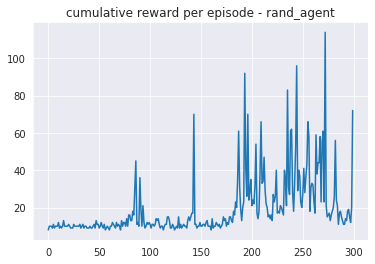

In [28]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
q_agent = DeepQAgent(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

### Experience replay

$L_i(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \left[ \left(r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s, a; \theta_i)\right)^2 \right]$

In [33]:
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1, memory_size = 2000, batch_size = 100):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
    #def replay(self, batch_size):
    #    x_batch =  np.zeros((batch_size, self.state_size))
    #    y_batch =  np.zeros((batch_size, self.action_size))
    #    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    #    for i, (state, action, reward, next_state, done) in enumerate(minibatch):
    #        target = self.model.predict(state.reshape(1,-1))[0]
    #        if done:
    #            target[action] = reward
    #        else:
    #            target[action] = reward + self.gamma * np.max(self.model.predict(next_state.reshape(1,-1)))
    #        x_batch[i] = state
    #        y_batch[i] = target
    #    return x_batch, y_batch
    
    def replay(self, batch_size):
        minibatch = np.array(random.sample(self.memory, min(len(self.memory), batch_size)))
        states = np.vstack(np.array(minibatch)[:,0])
        actions = np.array(minibatch)[:,1].astype(int)
        rewards = np.array(minibatch)[:,2]
        next_states = np.vstack(np.array(minibatch)[:,3])
        dones = np.array(minibatch)[:,4]
        targets = self.model.predict(states)
        targets_next = self.model.predict(next_states)
        targets[np.arange(actions.size),actions] = rewards + (1 - dones) * self.gamma * np.max(targets_next, axis=1)
        return states, targets
    
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

In [34]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)

q_agent = DeepQAgent_experience_replay(env, model)
rewards = run_experiment_episode_train(env, q_agent, 100)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 115.0
episode: 1 - cum reward 46.0
episode: 2 - cum reward 11.0
episode: 3 - cum reward 10.0
episode: 4 - cum reward 10.0
episode: 5 - cum reward 15.0
episode: 6 - cum reward 11.0
episode: 7 - cum reward 11.0
episode: 8 - cum rewar

KeyboardInterrupt: 

# Other improvments

### clipping
$Q(s,a):=Q(s,a)+\alpha(clip(r+\gamma \arg\max(Q(s',a'))-Q(s,a), -1, 1))$

cf tf.keras.losses.Huber(delta=10000.)

### Double Q learning

DQN: A reinforcement learning algorithm that combines Q-Learning with deep neural networks to let RL work for complex, high-dimensional environments, like video games, or robotics.
Double Q Learning: Corrects the stock DQN algorithm’s tendency to sometimes overestimate the values tied to specific actions.
Prioritized Replay: Extends DQN’s experience replay function by learning to replay memories where the real reward significantly diverges from the expected reward, letting the agent adjust itself in response to developing incorrect assumptions.
Dueling DQN: Splits the neural network into two — one learns to provide an estimate of the value at every timestep, and the other calculates potential advantages of each action, and the two are combined for a single action-advantage Q function.